# PDEFIND Feature Overview

This notebook provides a simple overview of the PDE functionality of PySINDy.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v0.13.0?filepath=example%2Ffeature_overview.ipynb)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso
from scipy.io import loadmat
import pysindy as ps
from sklearn.metrics import mean_squared_error
np.random.seed(100)

# Define Algorithm 2 from Rudy et al. (2017) 
We will see below that Algorithm 2 is required for stronger performance on the below examples. Note that Algorithm 2 is actually in the supplementary materials and the citation is:
Rudy, Samuel H., Steven L. Brunton, Joshua L. Proctor, and J. Nathan Kutz. "Data-driven discovery of partial differential equations." Science Advances 3, no. 4 (2017): e1602614. 

In [2]:
# Algorithm to scan over threshold values during Ridge Regression, and select
# highest performing model on the test set
def rudy_algorithm2(x_train, xdot_train, x_test, pde_lib, dtol, alpha=1e-5, tol_iter=25, 
                    normalize_columns=True, optimizer_max_iter=20, optimization="STLSQ"):
    if optimization == "STLSQ":
        optimizer = ps.STLSQ(threshold=0, alpha=0, max_iter=optimizer_max_iter, 
                  normalize_columns=normalize_columns, ridge_kw={'tol': 1e-10})
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
    model.fit(x_train, x_dot=xdot_train)
    # Set the L0 penalty based on the condition number of Theta
    l0_penalty = 1e-3 * optimizer.cond_num_
    coef_best = optimizer.coef_
    error_best = model.score(x_test, metric=mean_squared_error, squared=False
                            ) + l0_penalty * np.count_nonzero(coef_best)
    coef_history_ = np.zeros((coef_best.shape[0], coef_best.shape[1], 1 + tol_iter))
    error_history_ = np.zeros(1 + tol_iter)
    coef_history_[:, :, 0] = coef_best
    error_history_[0] = error_best
    tol = dtol
    for i in range(tol_iter):
        if optimization == "STLSQ":
            optimizer = ps.STLSQ(threshold=tol, alpha=alpha, max_iter=optimizer_max_iter,
                      normalize_columns=normalize_columns, ridge_kw={'tol': 1e-10})
        model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
        model.fit(x_train, x_dot=xdot_train)
        coef_new = optimizer.coef_
        print(coef_new)
        coef_history_[:, :, i + 1] = coef_new
        error_new = model.score(x_test, metric=mean_squared_error, squared=False
                                ) + l0_penalty * np.count_nonzero(coef_new)
        error_history_[i + 1] = error_new
        if error_new <= error_best:
            error_best = error_new
            coef_best = coef_new
            tol += dtol
        else:
            tol = max(0, tol - 2 * dtol)
            dtol = 2 * dtol / (tol_iter - i)
            tol += dtol
    return coef_best, error_best, coef_history_, error_history_

# Test PDE functionality on the 1D kdV equation
The kdV equation is
$u_t = -6uu_x - u_{xxx}$,
and the data we will be investigating is a two-soliton solution.

(512, 201) (201,) (512,)


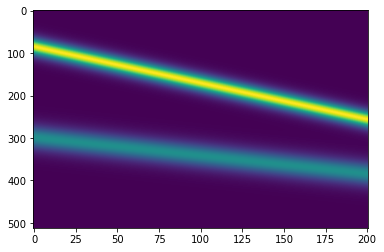

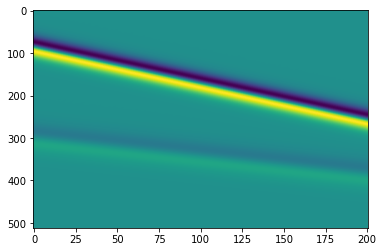

In [3]:
kdV = loadmat('data/kdv.mat')
t = np.ravel(kdV['t'])
x = np.ravel(kdV['x'])
u = np.real(kdV['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]
print(np.shape(u), np.shape(t), np.shape(x))
plt.figure()
plt.imshow(u, aspect='auto')
u_shaped = np.reshape(u, (len(x), len(t), 1))
plt.figure()
ut = np.zeros((len(x), len(t), 1))
for i in range(len(x)):
    ut[i, :, :] = ps.FiniteDifference()._differentiate(u_shaped[i, :, :], t=dt)
plt.imshow(ut, aspect='auto')

# Test spatial derivative computations

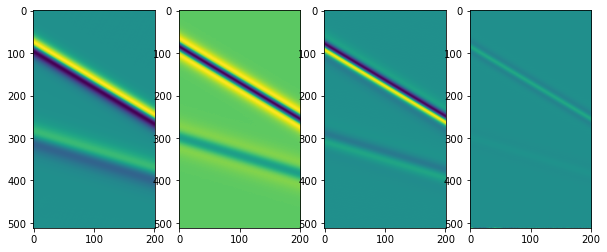

In [4]:
ux = np.zeros((len(x), len(t), 1))
uxx = np.zeros((len(x), len(t), 1))
uxxx = np.zeros((len(x), len(t), 1))
uxxxx = np.zeros((len(x), len(t), 1))
dx = x[1] - x[0]
for i in range(len(t)):
    u_temp = np.reshape(u[:, i], (len(u[:, i]), 1))
    ux[:, i] = ps.FiniteDifference(d=1)._differentiate(u_temp, dx)
    uxx[:, i] = ps.FiniteDifference(d=2)._differentiate(u_temp, dx)
    uxxx[:, i] = ps.FiniteDifference(d=3)._differentiate(u_temp, dx)
    uxxxx[:, i] = ps.FiniteDifference(d=4)._differentiate(u_temp, dx)
plt.figure(figsize=(10, 4))
plt.subplot(1, 4, 1)
plt.imshow(ux, aspect='auto')
plt.subplot(1, 4, 2)
plt.imshow(uxx, aspect='auto')
plt.subplot(1, 4, 3)
plt.imshow(uxxx, aspect='auto')
plt.subplot(1, 4, 4)
plt.imshow(uxxxx, aspect='auto')

In [5]:
train = np.random.choice(len(t), int(len(t) * 0.8), replace=False)
test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[:, train]
u_test = u[:, test]
ut_train = ut[:, train]
ut_test = ut[:, test]
t_train = t[train]
t_test = t[test]
u_train_flattened = np.reshape(u_train, (len(x) * len(t_train), 1), 'F')
ut_train_flattened = np.reshape(ut_train, (len(x) * len(t_train), 1), 'F')
u_test_flattened = np.reshape(u_test, (len(x) * len(t_test), 1), 'F')
ut_test_flattened = np.reshape(ut_test, (len(x) * len(t_test), 1), 'F')

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions, function_names=library_function_names, 
                        derivative_order=3, spatial_grid=x, include_bias=True)

optimizer = ps.STLSQ(threshold=5, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
model.print()

optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
model.print()

optimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15, 
                   thresholder='l1', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
model.print()

optimizer = ps.SSR(normalize_columns=True, L0_penalty=1e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
model.print()

optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, L0_penalty=1e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
model.print()

optimizer = ps.FROLS(normalize_columns=True, L0_penalty=1e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
model.print()

# Loops over thresholds and uses Ridge regression at each iteration
# dtol = 5
# alpha = 1e-5
# coef_best, err_best, coef_list, err_list = rudy_algorithm2(u_train_flattened, 
#                                        ut_train_flattened, u_test_flattened, 
#                                        pde_lib, dtol, alpha=alpha, tol_iter=25, 
#                                        normalize_columns=True, optimizer_max_iter=20, 
#                                        optimization="STLSQ")
# optimizer.coef_ = coef_best
# model.print()

x0' = -0.988 x0_111 + -5.956 x0x0_1
x0' = -0.988 x0_111 + -5.956 x0x0_1
x0' = -0.080 x0_1 + -0.905 x0_111 + -5.457 x0x0_1
x0' = -0.080 x0_1 + -0.905 x0_111 + -5.457 x0x0_1
x0' = -0.080 x0_1 + -0.905 x0_111 + -5.457 x0x0_1
x0' = -0.925 x0_1


# Test PDE functionality on the Kuramoto-Sivashinsky equation
The Kuramoto-Sivashinsky equation is
$u_t = -uu_x - u_{xx} - u_{xxxx}$.

(1024, 251) (251,) (1024,)


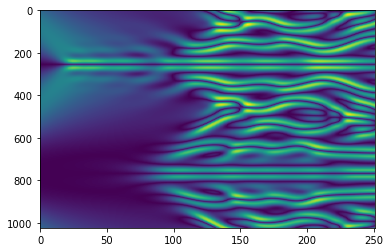

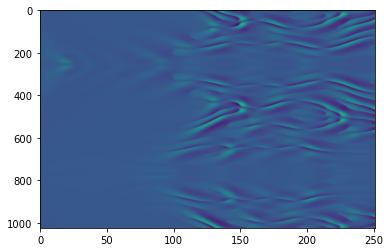

In [6]:
data = loadmat('data/kuramoto_sivishinky.mat')
t = np.ravel(data['tt'])
x = np.ravel(data['x'])
u = np.abs(data['uu']) 
dt = t[1] - t[0]
dx = x[1] - x[0]
print(np.shape(u), np.shape(t), np.shape(x))
plt.figure()
plt.imshow(u, aspect='auto')
u_shaped = np.reshape(u, (len(x), len(t), 1))
plt.figure()
ut = np.zeros((len(x), len(t), 1))
for i in range(len(x)):
    ut[i, :, :] = ps.FiniteDifference()._differentiate(u_shaped[i, :, :], t=dt)
plt.imshow(ut, aspect='auto')

In [7]:
train = np.random.choice(len(t), int(len(t) * 0.8), replace=False)
test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[:, train]
u_test = u[:, test]
ut_train = ut[:, train]
ut_test = ut[:, test]
t_train = t[train]
t_test = t[test]
u_train_flattened = np.reshape(u_train, (len(x) * len(t_train), 1), 'F')
ut_train_flattened = np.reshape(ut_train, (len(x) * len(t_train), 1), 'F')
u_test_flattened = np.reshape(u_test, (len(x) * len(t_test), 1), 'F')
ut_test_flattened = np.reshape(ut_test, (len(x) * len(t_test), 1), 'F')

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=4, spatial_grid=x, include_bias=True)

optimizer = ps.STLSQ(threshold=2, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
model.print()

optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
model.print()

optimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15, 
                   thresholder='l1', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
model.print()

optimizer = ps.SSR(normalize_columns=True, L0_penalty=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
model.print()

optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, L0_penalty=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
model.print()

# Loops over thresholds and uses Ridge regression at each iteration
# dtol = 5
# alpha = 1e-5
# coef_best, err_best, coef_list, err_list = rudy_algorithm2(u_train_flattened, 
#                                        ut_train_flattened, u_test_flattened, 
#                                        pde_lib, dtol, alpha=alpha, tol_iter=25, 
#                                        normalize_columns=True, optimizer_max_iter=20, 
#                                        optimization="STLSQ")
# optimizer.coef_ = coef_best
# model.print()

x0' = -0.015 1 + 0.088 x0 + -0.072 x0x0 + 0.002 x0_11 + 0.004 x0x0_11 + -0.025 x0x0x0_11
x0' = 0.055 x0 + -0.057 x0x0 + -0.021 x0x0x0_11
x0' = -0.013 1 + 0.083 x0 + -0.069 x0x0 + 0.001 x0_11 + -0.022 x0x0x0_11
x0' = -0.017 x0x0 + -0.028 x0x0_11
x0' = -0.018 x0x0 + -0.014 x0x0x0_11
[[-0.01155833  0.07857931 -0.06717403  0.          0.          0.
   0.          0.          0.          0.         -0.02195031  0.
   0.          0.          0.        ]]
[[ 0.          0.05488808 -0.05690864  0.          0.          0.
   0.          0.          0.          0.         -0.02103548  0.
   0.          0.          0.        ]]
[[ 0.          0.05488808 -0.05690864  0.          0.          0.
   0.          0.          0.          0.         -0.02103548  0.
   0.          0.          0.        ]]
[[ 0.          0.05488808 -0.05690864  0.          0.          0.
   0.          0.          0.          0.         -0.02103548  0.
   0.          0.          0.        ]]
[[ 0.          0.05488808 -0.0

/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/stlsq.py:178: UserWarning: Sparsity parameter is too big (30) and eliminated all coefficients
  "coefficients".format(self.threshold)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/stlsq.py:178: UserWarning: Sparsity parameter is too big (35) and eliminated all coefficients
  "coefficients".format(self.threshold)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/stlsq.py:178: UserWarning: Sparsity parameter is too big (40) and eliminated all coefficients
  "coefficients".format(self.threshold)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/stlsq.py:178: UserWarning: Sparsity parameter is too big (45) and eliminated all coefficients
  "coefficients".format(self.threshold)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/stlsq.py:178: UserWarning: Sparsity parameter is too big (50) and eliminated all coefficients
  "coefficients".format(self.threshold)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/stlsq.py:178: UserWarning: Sparsity parameter is too big (55) and eliminated all coefficients
  "coefficients".format(self.threshold)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/stlsq.py:178: UserWarning: Sparsity parameter is too big (60) and eliminated all coefficients
  "coefficients".format(self.threshold)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/stlsq.py:178: UserWarning: Sparsity parameter is too big (65) and eliminated all coefficients
  "coefficients".format(self.threshold)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/stlsq.py:178: UserWarning: Sparsity parameter is too big (70) and eliminated all coefficients
  "coefficients".format(self.threshold)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/stlsq.py:178: UserWarning: Sparsity parameter is too big (75) and eliminated all coefficients
  "coefficients".format(self.threshold)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/stlsq.py:178: UserWarning: Sparsity parameter is too big (80) and eliminated all coefficients
  "coefficients".format(self.threshold)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/stlsq.py:178: UserWarning: Sparsity parameter is too big (85) and eliminated all coefficients
  "coefficients".format(self.threshold)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/stlsq.py:178: UserWarning: Sparsity parameter is too big (90) and eliminated all coefficients
  "coefficients".format(self.threshold)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/stlsq.py:178: UserWarning: Sparsity parameter is too big (95) and eliminated all coefficients
  "coefficients".format(self.threshold)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/stlsq.py:178: UserWarning: Sparsity parameter is too big (100) and eliminated all coefficients
  "coefficients".format(self.threshold)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/stlsq.py:178: UserWarning: Sparsity parameter is too big (105) and eliminated all coefficients
  "coefficients".format(self.threshold)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/stlsq.py:178: UserWarning: Sparsity parameter is too big (110) and eliminated all coefficients
  "coefficients".format(self.threshold)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/stlsq.py:178: UserWarning: Sparsity parameter is too big (115) and eliminated all coefficients
  "coefficients".format(self.threshold)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/stlsq.py:178: UserWarning: Sparsity parameter is too big (120) and eliminated all coefficients
  "coefficients".format(self.threshold)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
x0' = 0.000


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/stlsq.py:178: UserWarning: Sparsity parameter is too big (125) and eliminated all coefficients
  "coefficients".format(self.threshold)


# Test PDE functionality on Burgers' equation
Burgers' equation is
$u_t = -uu_x - u_{xx}$.

(256, 101) (101,) (256,)


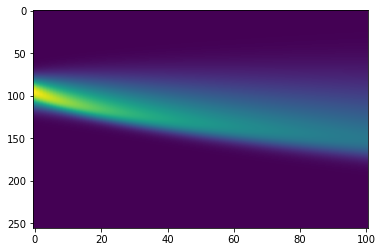

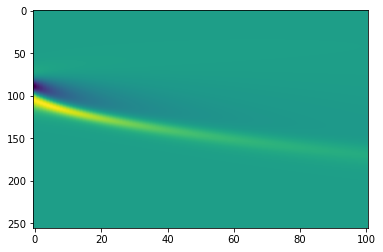

In [8]:
data = loadmat('data/burgers.mat')
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.abs(data['usol'])   #+ np.random.randn(len(x), len(t)) / 20
dt = t[1] - t[0]
dx = x[1] - x[0]
print(np.shape(u), np.shape(t), np.shape(x))
plt.figure()
plt.imshow(u, aspect='auto')
u_shaped = np.reshape(u, (len(x), len(t), 1))
plt.figure()
ut = np.zeros((len(x), len(t), 1))
for i in range(len(x)):
    ut[i, :, :] = ps.FiniteDifference()._differentiate(u_shaped[i, :, :], t=dt)
plt.imshow(ut, aspect='auto')

In [9]:
train = np.random.choice(len(t), int(len(t) * 0.8), replace=False)
test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[:, train]
u_test = u[:, test]
ut_train = ut[:, train]
ut_test = ut[:, test]
t_train = t[train]
t_test = t[test]
u_train_flattened = np.reshape(u_train, (len(x) * len(t_train), 1), 'F')
ut_train_flattened = np.reshape(ut_train, (len(x) * len(t_train), 1), 'F')
u_test_flattened = np.reshape(u_test, (len(x) * len(t_test), 1), 'F')
ut_test_flattened = np.reshape(ut_test, (len(x) * len(t_test), 1), 'F')

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=3, spatial_grid=x)

optimizer = ps.STLSQ(threshold=2, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
model.print()

optimizer = ps.SR3(threshold=2, max_iter=10000, tol=1e-15, nu=1e2,
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
model.print()

optimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15, 
                   thresholder='l1', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
model.print()

optimizer = ps.SSR(normalize_columns=True, L0_penalty=1e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
model.print()

optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, L0_penalty=1e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
model.print()

optimizer = ps.FROLS(normalize_columns=True, L0_penalty=1e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
model.print()

x0' = 0.100 x0_11 + -1.001 x0x0_1
x0' = 0.100 x0_11 + -1.001 x0x0_1
x0' = -0.001 x0_1 + 0.100 x0_11 + -0.998 x0x0_1
x0' = 0.100 x0_11 + -1.005 x0x0_1 + 0.009 x0x0x0_1
x0' = 0.100 x0_11 + -1.005 x0x0_1 + 0.009 x0x0x0_1
x0' = 0.100 x0_11 + -1.001 x0x0_1


# Test PDE functionality on Reaction-Diffusion system
This 2D system is significantly more complicated. The reaction-diffusion system exhibits spiral waves on a periodic domain,and the PDEs are:
$$u_t = 0.1\nabla^2 u + (1-A^2)u +\beta A^2v$$
$$v_t = 0.1\nabla^2 v - \beta A^2 u + (1-A^2)v$$
$$A^2 = u^2 + v^2.$$
The main change will be a significantly larger library... cubic terms in (u, v) and all their first and second order derivatives. 

(128,) (128,)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


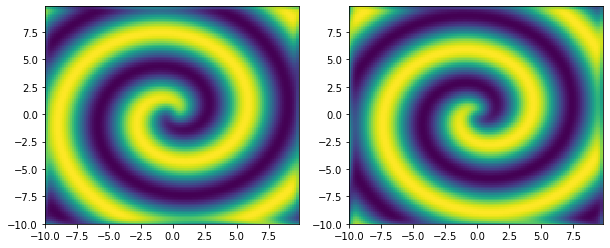

In [10]:
from scipy.integrate import solve_ivp
from numpy.fft import fft2, ifft2

def reaction_diffusion(t, uvt, K22, d1, d2, beta, n, N):
    ut = np.reshape(uvt[:N], (n, n))
    vt = np.reshape(uvt[N:2 * N], (n, n))
    u = np.real(ifft2(ut))
    v = np.real(ifft2(vt))
    u3 = u ** 3
    v3 = v ** 3
    u2v = (u ** 2) * v
    uv2 = u * (v ** 2)
    utrhs = np.reshape((fft2(u - u3 - uv2 + beta * u2v + beta * v3)), (N, 1))
    vtrhs = np.reshape((fft2(v - u2v - v3 - beta * u3 - beta * uv2)), (N, 1))
    uvt_reshaped = np.reshape(uvt, (len(uvt), 1))
    uvt_updated = np.squeeze(np.vstack((-d1 * K22 * uvt_reshaped[:N] + utrhs, -d2 * K22 * uvt_reshaped[N:] + vtrhs)))
    return uvt_updated


# Need to generate the data
t = np.linspace(0, 10, int(10 / 0.05))
d1 = 0.1
d2 = 0.1
beta = 1.0
L = 20
n = 128  # 64 for speed but derivatives are terrible looking
N = n * n;
x2 = np.linspace(- L / 2, L / 2, n + 1)
x = x2[:n]
y = x
n2 = int(n / 2)
kx = (2 * np.pi / L) * np.hstack((np.linspace(0, n2 - 1, n2), np.linspace(- n2, - 1, n2)))
ky = kx
print(x.shape, kx.shape)
X, Y = np.meshgrid(x, y)
KX, KY = np.meshgrid(kx, ky)
K2 = KX ** 2 + KY ** 2
K22 = np.reshape(K2, (N, 1))

m = 1  # number of spirals

u = np.zeros((len(x), len(y), len(t)))
v = np.zeros((len(x), len(y), len(t)))

u[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.cos(m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2)))
v[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.sin(m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2)))

uvt = np.squeeze(np.hstack((np.reshape(fft2(u[:, :, 0]), (1, N)), np.reshape(fft2(v[:, :, 0]), (1, N)))))
uvsol = solve_ivp(reaction_diffusion, (t[0], t[-1]), y0=uvt, t_eval=t, args=(K22, d1, d2, beta, n, N))
uvsol = uvsol.y

for j in range(len(t)):
    ut = np.reshape(uvsol[:N, j], (n, n))
    vt = np.reshape(uvsol[N:, j], (n, n))
    u[:, :, j] = np.real(ifft2(ut))
    v[:, :, j] = np.real(ifft2(vt))
    
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolor(X, Y, u[:, :, 10])
plt.subplot(1, 2, 2)
plt.pcolor(X, Y, v[:, :, 10])

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]

u_sol = u
v_sol = v

In [11]:
u = np.zeros((n, n, len(t), 2))
u[:, :, :, 0] = u_sol
u[:, :, :, 1] = v_sol
ut = np.zeros((n, n, len(t), 2))
for i in range(n):
    for j in range(n):
        ut[i, j, :, :] = ps.FiniteDifference()._differentiate(u[i, j, :, :], dt)
        
train = np.random.choice(len(t), int(len(t) * 0.4), replace=False)
test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[:, :, train, :]
u_test = u[:, :, test, :]
ut_train = ut[:, :, train, :]
ut_test = ut[:, :, test, :]
t_train = t[train]
t_test = t[test]
spatial_grid = np.asarray([X, Y]).T
u_train_flattened = np.reshape(u_train, (N * len(t_train), 2), 'F')
ut_train_flattened = np.reshape(ut_train, (N * len(t_train), 2), 'F')
u_test_flattened = np.reshape(u_test, (N * len(t_test), 2), 'F')
ut_test_flattened = np.reshape(ut_test, (N * len(t_test), 2), 'F')

In [36]:
library_functions = [lambda x: x, lambda x: x * x * x, lambda x, y: x * y * y, lambda x, y: x * x * y]
library_function_names = [lambda x: x, lambda x: x + x + x, lambda x, y: x + y + y, lambda x, y: x + x + y]
pde_lib = ps.PDELibrary(library_functions=library_functions, function_names=library_function_names, 
                        derivative_order=2, spatial_grid=spatial_grid, include_bias=True)

optimizer = ps.STLSQ(threshold=40, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
model.print()

# optimizer = ps.SR3(threshold=40, max_iter=10000, tol=1e-15, nu=1e2,
#                    thresholder='l0', normalize_columns=True)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_train_flattened, x_dot=ut_train_flattened)
# model.print()

# optimizer = ps.SR3(threshold=20, max_iter=10000, tol=1e-15, nu=1e2,
#                    thresholder='l1', normalize_columns=True)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_train_flattened, x_dot=ut_train_flattened)
# model.print()

# optimizer = ps.SSR(normalize_columns=True, L0_penalty=1e-1, max_iter=100)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_train_flattened, x_dot=ut_train_flattened)
# model.print()

# optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, L0_penalty=1e-1, max_iter=100)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_train_flattened, x_dot=ut_train_flattened)
# model.print()

# optimizer = ps.FROLS(normalize_columns=True, L0_penalty=1e-2)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_train_flattened, x_dot=ut_train_flattened)
# model.print()

feature_names = np.asarray(model.get_feature_names())
n_features = len(feature_names)
print(np.where(feature_names == 'x0_11'))
print(np.where(feature_names == 'x0_22'))
print(np.where(feature_names == 'x1_11'))
print(np.where(feature_names == 'x1_22'))
print(feature_names)
n_targets = u_train_flattened.shape[1]
constraint_rhs = np.zeros(2)
constraint_lhs = np.zeros((2, n_targets * n_features))
# 1 * (u_xx coefficient) - 1 * (u_yy coefficient) = 0
constraint_lhs[0, 11] = 1
constraint_lhs[0, 15] = -1
# 1 * (v_xx coefficient) - 1 * (v_yy coefficient) = 0
constraint_lhs[1, 12] = 1
constraint_lhs[1, 16] = -1

optimizer = ps.ConstrainedSR3(
                threshold=30, max_iter=400, tol=1e-6, nu=1e2,
                thresholder='l0', normalize_columns=True, 
                constraint_rhs=constraint_rhs, 
                constraint_lhs=constraint_lhs,
                #constraint_order='feature'
            )
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
model.print()
print(optimizer.coef_full_[0, 11], optimizer.coef_full_[0, 15], optimizer.coef_full_)
# Loops over thresholds and uses Ridge regression at each iteration
# dtol = 1
# alpha = 1e-5
# coef_best, err_best, coef_list, err_list = rudy_algorithm2(u_train_flattened, 
#                                        ut_train_flattened, u_test_flattened, 
#                                        pde_lib, dtol, alpha=alpha, tol_iter=10, 
#                                        normalize_columns=True, optimizer_max_iter=20, 
#                                        optimization="STLSQ")
# optimizer.coef_ = coef_best
# model.print()

x0' = 1.013 x0 + -1.013 x0x0x0 + 1.000 x1x1x1 + -1.012 x0x1x1 + 0.999 x0x0x1 + 0.101 x0_11 + 0.102 x0_22
x1' = 1.013 x1 + -1.000 x0x0x0 + -1.013 x1x1x1 + -0.999 x0x1x1 + -1.013 x0x0x1 + 0.102 x1_11 + 0.101 x1_22
(array([11]),)
(array([15]),)
(array([12]),)
(array([16]),)
['1' 'x0' 'x1' 'x0x0x0' 'x1x1x1' 'x0x1x1' 'x0x0x1' 'x0_1' 'x1_1' 'x0_2'
 'x1_2' 'x0_11' 'x1_11' 'x0_12' 'x1_12' 'x0_22' 'x1_22' 'x0x0_1' 'x0x1_1'
 'x1x0_1' 'x1x1_1' 'x0x0x0x0_1' 'x0x0x0x1_1' 'x1x1x1x0_1' 'x1x1x1x1_1'
 'x0x1x1x0_1' 'x0x1x1x1_1' 'x0x0x1x0_1' 'x0x0x1x1_1' 'x0x0_2' 'x0x1_2'
 'x1x0_2' 'x1x1_2' 'x0x0x0x0_2' 'x0x0x0x1_2' 'x1x1x1x0_2' 'x1x1x1x1_2'
 'x0x1x1x0_2' 'x0x1x1x1_2' 'x0x0x1x0_2' 'x0x0x1x1_2' 'x0x0_11' 'x0x1_11'
 'x1x0_11' 'x1x1_11' 'x0x0x0x0_11' 'x0x0x0x1_11' 'x1x1x1x0_11'
 'x1x1x1x1_11' 'x0x1x1x0_11' 'x0x1x1x1_11' 'x0x0x1x0_11' 'x0x0x1x1_11'
 'x0x0_12' 'x0x1_12' 'x1x0_12' 'x1x1_12' 'x0x0x0x0_12' 'x0x0x0x1_12'
 'x1x1x1x0_12' 'x1x1x1x1_12' 'x0x1x1x0_12' 'x0x1x1x1_12' 'x0x0x1x0_12'
 'x0x0x1x1_12' 'x0x0_2

/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/constrained_sr3.py:317: ConvergenceWarning: SR3._reduce did not converge after 400 iterations.
  ConvergenceWarning,


In [37]:
feature_names[11]

'x0_11'

In [38]:
optimizer.coef_[0, 11]

0.09558128051124183

In [51]:
np.where(np.asarray(optimizer.coef_[0, :]) == optimizer.coef_[0, 15])

(array([15]),)